In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import argparse
from create_reference_from_tsv_and_pepxml import ReferenceWriter
from sensitivity_calculator import SensitivityAndSpecificity
from create_PSM_df import PSM_FDR

In [41]:
# Files
uniprot_nr_species_tsv_with_wrong_error = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_new_reduced.tsv"


reference_tsv_with_kleiner_db = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_kleiner_db/Run1_U1_2000ng.t.xml_reduced.tsv"
reference_tsv_with_aradiopsis = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_kleiner_reference_aradiopsis/Run1_U1_2000ng_kleiner_aradiopsis.t.xml_reduced.tsv"
path_to_bachelor_results = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/"
path_to_uniprot_reanalysis = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_reanalysis_uniprot"
path_to_tanca_results_bachelor = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/9MM_FASP/x_tandem_tsv"

def get_path_to_refernce_analysis_results(fdr):
    return f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_kleiner_db/Run1_U1_2000ng.t.xml_reduced.tsv_{fdr}_sensitivity_new"

def get_path_to_refernce_analysis_results_with_aradiopsis(fdr):
    return f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_kleiner_reference_aradiopsis/Run1_U1_2000ng_kleiner_aradiopsis.t.xml_reduced.tsv_{fdr}_sensitivity_new"



uniprot_reanalysis = {'species': path_to_uniprot_reanalysis + "/species/Run1_U1_2000ng_uniprot_species.t.xml_new_reduced.tsv",
                      'species_nr': path_to_uniprot_reanalysis + "/species_nr/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv",
                      "species_species": path_to_uniprot_reanalysis + "/species_species/Run1_U1_2000ng_uniprot_species_species.t.xml_reduced.tsv",
                      'genus_nr': path_to_uniprot_reanalysis + "/genus_nr/Run1_U1_2000ng_uniprot_genus_nr.t.xml_reduced.tsv"
                     }
    
uniprot_nr_reduced_tsv = {
    'subspecies': path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_subspecies.t.xml_new_reduced.tsv",
    'species': path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_new_reduced.tsv",
    'genus': path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_nr.t.xml_new_reduced.tsv",
    'family': path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_family_nr.t.xml_new_reduced.tsv",
}
    
uniprot_reduced_tsv = {
    'subspecies': path_to_bachelor_results + "/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_subspecies.t.xml_new_reduced.tsv",
    'species': path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_species.t.xml_new_reduced.tsv",
    'genus': path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus.t.xml_new_reduced.tsv"
}

uniprot_species_reduced_tsv =  {
    'subspecies': path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_subspecies.t.xml_new_reduced.tsv",
    'species': path_to_uniprot_reanalysis + "/species_species/Run1_U1_2000ng_uniprot_species_species.t.xml_new_reduced.tsv",
    'genus':  path_to_bachelor_results + "/uniprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_uniprot_genus_species.t.xml_new_reduced.tsv"
}

ncbi_reduced_tsv= {
    'subspecies': path_to_bachelor_results + "/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_subspecies.t.xml_new_reduced.tsv",
    'species': path_to_bachelor_results + "/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_species.t.xml_new_reduced.tsv",
    'genus': path_to_bachelor_results + "/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_genus.t.xml_new_reduced.tsv"
}

ncbi_species_reduced_tsv = {
    'species': path_to_bachelor_results + "/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_species_species.t.xml_new_reduced.tsv",
    'genus': path_to_bachelor_results + "/ncbi_kleiner/x_tandem_tsv/Run1_U1_2000ng_ncbi_kleiner_genus_species.t.xml_new_reduced.tsv"
}
swissprot_reduced_tsv = {
    'species': path_to_bachelor_results + "/swissprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_swissprot_species.t.xml_new_reduced.tsv",
    'genus': path_to_bachelor_results + "/swissprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_swissprot_genus.t.xml_new_reduced.tsv",
    'family': path_to_bachelor_results + "/swissprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_swissprot_family.t.xml_new_reduced.tsv",
    'order': path_to_bachelor_results + "/swissprot_kleiner/x_tandem_tsv/Run1_U1_2000ng_swissprot_order.t.xml_new_reduced.tsv"
}

tanca_ncbi_tsv = {
    'species': path_to_tanca_results_bachelor + "/9MM_FASP_ncbi_Tanca_species.t.xml_new_reduced.tsv",
    'genus': path_to_tanca_results_bachelor + "/9MM_FASP_ncbi_tanca_genus.t.xml_new_reduced.tsv",
    'family': path_to_tanca_results_bachelor + "/9MM_FASP_ncbi_tanca_family.t.xml_new_reduced.tsv",
}

tanca_uniprot_tsv = {
    'species': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_species_nr.t.xml_new_reduced.tsv",
    'genus': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_genus.t.xml_new_reduced.tsv",
    'family': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_family_nr.t.xml_new_reduced.tsv",
    'order': path_to_tanca_results_bachelor + "/9MM_FASP_uniprot_Tanca_order_nr.t.xml_new_reduced.tsv"
}

tanca_swissprot_tsv = {
    'species': path_to_tanca_results_bachelor + "/9MM_FASP_swissprot_tanca_species.t.xml_new_reduced.tsv",
    'genus': path_to_tanca_results_bachelor + "/9MM_FASP_swissprot_tanca_genus.t.xml_new_reduced.tsv",
    'family': path_to_tanca_results_bachelor + "/9MM_FASP_swissprot_tanca_family.t.xml_new_reduced.tsv",
    'order': path_to_tanca_results_bachelor + "/9MM_FASP_swissprot_tanca_order.t.xml_new_reduced.tsv"
}

def get_dict_databases_to_size_and_result_file(fdr):
    dict_databases_to_size_and_result_file={'reference': (123088, f"{reference_tsv_with_kleiner_db}_{fdr}_sensitivity_new"),
                                        "reference_with_aradiopsis": (138980, f"{reference_tsv_with_aradiopsis}_{fdr}_sensitivity_new"),
                                        
                                        'ncbi_subspecies': (300000, f"{ncbi_reduced_tsv['subspecies']}_{fdr}_sensitivity_new"),
                                        'ncbi_species': (8702135, f"{ncbi_reduced_tsv['species']}_{fdr}_sensitivity_new"),
                                        "ncbi_genus":(27804893, f"{ncbi_reduced_tsv['genus']}_{fdr}_sensitivity_new"),
                                        
                                        "uniprot_subspecies": (4683371, f"{uniprot_reduced_tsv['subspecies']}_{fdr}_sensitivity_new"),
                                        "uniprot_species": (4683371, f"{uniprot_reduced_tsv['species']}_{fdr}_sensitivity_new"),
                                        "uniprot_species_species": (2093157, f"{uniprot_species_reduced_tsv['species']}_{fdr}_sensitivity_new"),
                                        "uniprot_subspecies_nr": (200000, f"{uniprot_nr_reduced_tsv['subspecies']}_{fdr}_sensitivity_new"),
                                        "uniprot_species_nr": (2991727, f"{uniprot_nr_reduced_tsv['species']}_{fdr}_sensitivity_new"),
                                        "uniprot_genus": (18352148,  f"{uniprot_reduced_tsv['genus']}_{fdr}_sensitivity_new"),
                                        "uniprot_genus_species": (13068285,  f"{uniprot_species_reduced_tsv['genus']}_{fdr}_sensitivity_new"),
                                        "uniprot_genus_nr": (13210287,  f"{uniprot_nr_reduced_tsv['genus']}_{fdr}_sensitivity_new"),
                                        "uniprot_family_nr": (22509624, f"{uniprot_nr_reduced_tsv['family']}_{fdr}_sensitivity_new"),
                                        
                                        "swissprot_species": (58505, f"{swissprot_reduced_tsv['species']}_{fdr}_sensitivity_new"),
                                        "swissprot_genus": (88164, f"{swissprot_reduced_tsv['genus']}_{fdr}_sensitivity_new" ),
                                        "swissprot_family": (124044, f"{swissprot_reduced_tsv['family']}_{fdr}_sensitivity_new"),
                                        "swissprot_order": (181725, f"{swissprot_reduced_tsv['order']}_{fdr}_sensitivity_new")
                                       }
    return dict_databases_to_size_and_result_file

dict_databases_to_size_and_result_file = get_dict_databases_to_size_and_result_file(0.05)
uniprot_dict =dict(filter(lambda item: item[0] in ['uniprot_subspecies', 'uniprot_species', 'uniprot_genus'], dict_databases_to_size_and_result_file.items()))
uniprot_nr_dict =dict(filter(lambda item: '_nr' in item[0], dict_databases_to_size_and_result_file.items()))
uniprot_species_dict=dict(filter(lambda item: item[0] in ['uniprot_species_species', 'uniprot_genus_species'], dict_databases_to_size_and_result_file.items()))
ncbi_dict =dict(filter(lambda item: 'ncbi' in item[0], dict_databases_to_size_and_result_file.items()))
swissprot_dict=dict(filter(lambda item: 'swiss' in item[0], dict_databases_to_size_and_result_file.items()))

In [3]:
def get_all_rows_without_charge1(title_col):
    return [title.split('.')[-1] != '' for title in title_col]

def remove_spectra_of_charge_one_from_reduced_tsv(reduced_tsv):
    return reduced_tsv[get_all_rows_without_charge1(reduced_tsv.Title)]

def read_all_results_into_dict(file):
    result_dict= {}
    with open(file, 'r') as inp:
        firstline=inp.readline()
        db_names = [name.strip() for name in firstline.strip().split('\t')[1:]]
        for db in db_names:
            result_dict[db] = {}
        for line in inp.readlines():
            result_name = line.split('\t')[0]
            result_fields = [name.strip() for name in line.split('\t')[1:]]
            for i, db in enumerate(db_names):
                result_dict[db][result_name]=result_fields[i]
    return result_dict

def read_analysis_results_into_dict(file):
    result_dict= {}
    with open(file, 'r') as inp:
        for line in inp.readlines():
            result_dict[line.split('\t')[0]] = line.split('\t')[1].strip()
   #print(result_dict)
    return result_dict

def read_TP(file):
    TP = int(read_analysis_results_into_dict(file)['TP:'])
    return TP

def read_TN(file):
    TN = int(read_analysis_results_into_dict(file)['TN:'])
    return TN

def read_FP(file):
    TP = int(read_analysis_results_into_dict(file)['FP:'])
    return TP

def read_FN(file):
    TN = int(read_analysis_results_into_dict(file)['FN:'])
    return TN

def read_sensitivity(file):
    sen = float(read_analysis_results_into_dict(file)['sensitivity:'])
    return sen
 
def read_specificity(file):
    spe = float(read_analysis_results_into_dict(file)['specificity:'])
    return spe


def read_value_from_result_file(file, database, level, column_of_interest):
    df = pd.read_csv(file, sep='\t')
    value = df.loc[(df['level'] == level) & (df['database'] == database)][column_of_interest]
    return value.values[0]


In [4]:
def get_score_results(filtered_dict):   
    db_size = []
    score_border = []
    result_dict = {}
    for file_name, db_size_file_tuple in filtered_dict.items():
        result_dict[file_name] = {'db_size': db_size_file_tuple[0]/100000, 'score_border': read_last_score(db_size_file_tuple[1])}

    for k, v in result_dict.items():
        db_size.append(v['db_size'])
        score_border.append(v['score_border'])
    return result_dict, db_size, score_border

def get_specificity_results(filtered_dict):   
    db_size = []
    score_border = []
    result_dict = {}
    for file_name, db_size_file_tuple in filtered_dict.items():
        result_dict[file_name] = {'db_size': db_size_file_tuple[0]/100000, 'specificity': read_specificity(db_size_file_tuple[1])}
    for k, v in result_dict.items():
        db_size.append(v['db_size'])
        score_border.append(v['specificity'])
    return result_dict, db_size, score_border

In [5]:
def get_decoy_rows_from_decoy_column(decoy_column):
    return [True if d=={True} else False for d in decoy_column]

def get_tax_rows(tax_column, taxid):
    return [True if tax_set == {taxid} else False for tax_set in tax_column]

def get_decoy_rows_from_protein_column(protein_column):
    return [True if 'REVERSED' in p else False for p in protein_column]


def get_hit_rows(protein_column):
    return [False if 'REVERSED' in p else True for p in protein_column]

def get_decoy_rows2(decoy_column):
    return [True if d_set in [{True, False}, {True}] else False for d_set in decoy_column]

def get_hit_rows2(decoy_column):
    return [True if d_set in  [{True, False}, {False}] else False for d_set in decoy_column]

def get_not_crap_rows(column_name):
    return [True if t_set != {"CRAP"} else False for t_set in column_name]

In [6]:
def read_result_df(f):
    df =  ReferenceWriter.read_csv_with_generic_function(f,['Hyperscore', 'taxID', 'decoy'])
    return df[['Title', 'Peptide', 'Hyperscore', 'taxID', 'decoy']]
    
def get_psm_and_df_in_fdr(file, fdr, remove_one_charged_spectra=False, columns=None):
    cs = ['Protein', 'Hyperscore', 'decoy', 'taxID']
    if columns:
        cs = cs + columns
    reduced_df = ReferenceWriter.read_csv_with_generic_function(file, cs, remove_one_charged_spectra)
    fdr_pos_result, number_psm_result, number_decoy_result, double_spectra_result, score_last_item_result =PSM_FDR.determine_FDR_position(reduced_df, fdr)
    return number_psm_result, reduced_df[0:fdr_pos_result]

In [7]:
# Histogramm
def create_df_for_df_with_sep_decoy(df_reduced_tsv):
    """
    decoy column values of reduced_tsv file changed to 'PSM' for  {False} and 'DECOY' for {TRUE}
    {True, False} values doubled, one as 'PSM' one as 'DECOY'
    :return:  Title(=spectrum ID) | Protein set {acc1, acc2} | Hyperscore (float) | decoy (PSM or DECOY)
    """
    def get_true_false(decoy_column):
        l = [True if decoy == {True, False} else False for decoy in decoy_column]
        return l
    # reduce df to columns 'Title', 'Protein', 'Hyperscore', 'decoy'
   # df_reduced_tsv = df_reduced_tsv[['Title', 'Protein', 'Hyperscore', 'decoy']]
    # df only with rows with value {True, False} in column "decoy"
    df_true_false = df_reduced_tsv[get_true_false(df_reduced_tsv.decoy)]
    # df only with rows with value {True, False} in column "decoy"  copyied
    df_true = df_true_false.copy(deep=True)
    # df value {True, False} in column "decoy" changed to {True}
    df_true.decoy=[{True} for v in df_true.decoy]
    # copied original df with columns 'Title', 'Protein', 'Hyperscore', 'decoy'
    df_with_sep_decoy= df_reduced_tsv.copy(deep=True)
    # decoy column value {False, True} changed to False
    df_with_sep_decoy.decoy = [{False} if v == {False, True} else v for v in df_with_sep_decoy.decoy ]
    # df_true rows appended, so decoy entries with {False True} doubled, one with {true}, once with {False}}
    df_with_sep_decoy = df_with_sep_decoy.append(df_true, ignore_index=True)
    # replace decoy value {True} by DECOY {False} by 'PSM'
    df_with_sep_decoy.decoy=['DECOY' if v == {True} else 'PSM' for v in df_with_sep_decoy.decoy]
    return df_with_sep_decoy


In [8]:

def create_all_level_df_for_histogram_per_db(database_reduced_tsv, db_levels):
    """
    database_reduced_tsv e.g. uniprot_nr_reduced_tsv (dict) or list of paths to reduced tsvs
    db_levels: e.g.[species, genus...] or [db_1, db_2]
    """
    
    df_reduced_tsv_list = []
    result_df_list = []
    
    if type(database_reduced_tsv)==list:
        for reduced_tsv in database_reduced_tsv:
            df_reduced_tsv_list.append(ReferenceWriter.read_csv_with_generic_function(reduced_tsv,['Hyperscore',  'decoy'])[['Title', 'Hyperscore',  'decoy']])
        for i, df_reduced_tsv in enumerate(df_reduced_tsv_list):
            df_level = create_df_for_df_with_sep_decoy(df_reduced_tsv)
            df_level['database'] = db_levels[i]
            result_df_list.append(df_level)            
    else:   
        for level in db_levels:
            df_reduced_tsv_list.append(ReferenceWriter.read_csv_with_generic_function(database_reduced_tsv[level],['Hyperscore',  'decoy'])[['Title', 'Hyperscore',  'decoy']])
        for i, df_reduced_tsv in enumerate(df_reduced_tsv_list):
            df_level = create_df_for_df_with_sep_decoy(df_reduced_tsv)
            # change subspecies to strain
            if db_levels[i] == 'subspecies':
                level = 'strain'
            else:
                level = db_levels[i]
            df_level['level'] = level
            result_df_list.append(df_level)      
    df_all_level = pd.concat(result_df_list)
    return df_all_level

def get_all_fdr_borders_per_db(db_dict, db_names):
    border_list = []
    for name in (db_names):
        fdr_border_level = float(read_last_score(db_dict[name][1]))
        border_list.append(fdr_border_level)
    return border_list

In [9]:
# create df sensitivity analysis and save
def create_sens_dict(file, db, level):
    d = read_analysis_results_into_dict(file)
    d['database'] = db
    d['level'] = level
    return d

def create_all_analysis_result_df(fdr, tanca=False):
    dict_databases_to_size_and_result_file = get_dict_databases_to_size_and_result_file(fdr)
    d_list = []
    for level in ['subspecies', 'species', 'genus', 'family', 'order']:
        try:
            d = create_sens_dict(dict_databases_to_size_and_result_file[f'uniprot_{level}_nr'][1], 'uniprot_nr', level)
            d_list.append(d)
        except FileNotFoundError:
            pass
        except KeyError:
            pass
        try:
            d = create_sens_dict(dict_databases_to_size_and_result_file[f'uniprot_{level}'][1], 'uniprot', level)
            d_list.append(d)
        except FileNotFoundError:
            pass
        except KeyError:
            pass
        try:
            d = create_sens_dict(dict_databases_to_size_and_result_file[f'ncbi_{level}'][1], 'ncbi', level)
            d_list.append(d)
        except FileNotFoundError:
            pass
        except KeyError:
            pass
        try:
            d = create_sens_dict(dict_databases_to_size_and_result_file[f'swissprot_{level}'][1], 'swissprot', level)
            d_list.append(d)
        except FileNotFoundError:
            pass
        except KeyError:
            pass
    ref_list= []
    ref_d =create_sens_dict(get_path_to_refernce_analysis_results(fdr), 'reference', '-')
    ref_list.insert(0, ref_d)
    ref_d =create_sens_dict(get_path_to_refernce_analysis_results_with_aradiopsis(fdr), 'reference with aradiopsis seq', '-')
    ref_list.append(ref_d)

    full_df = pd.DataFrame(d_list)
    full_df = full_df.sort_values(by=['database'], ignore_index=True)
    full_df = pd.concat([pd.DataFrame(ref_list), full_df],  ignore_index=True)
    full_df.columns = [head[0:-1] if head.endswith(':') else head for head in list(full_df.columns) ]
    full_df = full_df.rename(columns={'Number of spectra identified in result but not in reference': "nb additional identified spectra", 
                            "Number of spectra identified in result": "nb identified spectra",
                           "Number of PSMs in result": "nb PSMs",
                           "Hyperscore of last item in FDR boundaries": "lowest score in FDR"})
    df = full_df[['database', 'level', 'specificity', 'sensitivity', 'TP', 'FP', 'TN', 'FN', "nb additional identified spectra",
                 "nb identified spectra", "nb PSMs", "lowest score in FDR"]]
    return df


In [10]:
# database-size vs. PSMs
def get_psm_per_db_from_sens_analysis(df, db):
    PSM_identified = []
    if db == 'uniprot':
        PSM_identified.append(int(df.loc[df['database'] == 'uniprot' ].loc[df['level'] == 'subspecies']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'uniprot_nr' ].loc[df['level'] == 'species']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'uniprot_nr' ].loc[df['level'] == 'genus']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'uniprot_nr' ].loc[df['level'] == 'family']['nb PSMs']))
        
    if db == 'ncbi':
        PSM_identified.append(int(df.loc[df['database'] == 'ncbi' ].loc[df['level'] == 'subspecies']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'ncbi' ].loc[df['level'] == 'species']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'ncbi' ].loc[df['level'] == 'genus']['nb PSMs']))
        
    if db == 'swissprot':        
        PSM_identified.append(int(df.loc[df['database'] == 'swissprot' ].loc[df['level'] == 'species']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'swissprot' ].loc[df['level'] == 'genus']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'swissprot' ].loc[df['level'] == 'family']['nb PSMs']))
        PSM_identified.append(int(df.loc[df['database'] == 'swissprot' ].loc[df['level'] == 'order']['nb PSMs']))
    return PSM_identified

def create_pd_df_for_psm_plot(PSM_identified_uniprot_percentage, PSM_identified_ncbi_percentage, uniprot_database_sizes, ncbi_database_sizes, PSM_identified_swissprot_percentage=None, swissprot_database_sizes=None):
    database = ['UniProtKB' for e in PSM_identified_uniprot_percentage]
    database.extend(['NCBI' for e in PSM_identified_ncbi_percentage])
    if PSM_identified_swissprot_percentage:
        database.extend(['Swissprot' for e in PSM_identified_swissprot_percentage])
    psms = PSM_identified_uniprot_percentage + PSM_identified_ncbi_percentage 
    if PSM_identified_swissprot_percentage:
        psms = psms + PSM_identified_swissprot_percentage
    dataset = ['kleiner' for e in  database]
    level = ['strain', 'species', 'genus', 'family', 'strain', 'species', 'genus']
    if PSM_identified_swissprot_percentage:
        level = level + ['species', 'genus', 'family', 'order']

    database_size = uniprot_database_sizes + ncbi_database_sizes
    if swissprot_database_sizes:
        database_size = database_size + swissprot_database_sizes
    DatabaseSize = pd.DataFrame(list(zip(database_size, level, psms, database, dataset)), columns =['# fasta (M)', 'level', '% PSMs identified', 'database', 'dataset'])
    return DatabaseSize

In [11]:
# identified spectra in all levels together: 36,84%, deutlich abweichender Wert von Bachelorarbeit 26%:
def get_decoy_rows_from_decoy_column_from_merged_df(decoy_column):
    result=[]
    for d in decoy_column:
        # nan 
        if type(d) != set:
            result.append(True)
        elif  d=={True}:
            result.append(True)
        elif  d=={False}:
            result.append(False)
        elif  d=={True, False}:
            result.append(False)
        else:
            print(d)
    return result

def get_merged_df_of_all_levels(reduced_tsv_file_dict, fdr, levels):
    dfs_in_fdr = []
    decoy_columns = []
    for level in levels:
        number_psm_result, reduced_df_in_fdr = get_psm_and_df_in_fdr(reduced_tsv_file_dict[level], fdr)[1]
        reduced_df_in_fdr = reduced_df_in_fdr.rename(columns={'decoy': f'decoy_{level}'})
        decoy_columns.append(f'decoy_{level}')
        dfs_in_fdr.append(reduced_df_in_fdr)
    
    merged_df = pd.DataFrame(columns=["Title"])
    for reduced_df_in_fdr in dfs_in_fdr:
        merged_df = pd.merge(merged_df, reduced_df_in_fdr, how="outer", on='Title')

    decoy_lists_per_level = []
    for decoy_column_name in decoy_columns:
        decoy_list_per_level = get_decoy_rows_from_decoy_column_from_merged_df(merged_df[decoy_column_name])
        decoy_lists_per_level.append(decoy_list_per_level)
    
    final_decoy_list= []
    for decoy_tuple in zip(*decoy_lists_per_level):
        if False in decoy_tuple:
            final_decoy_list.append(True)
        else:
            final_decoy_list.append(False)
            
    identified_spectra_of_all_levels_together = len(set(merged_df[final_decoy_list]['Title']))
    return merged_df, final_decoy_list, identified_spectra_of_all_levels_together



In [12]:
def count_spectra_per_taxon(reduced_df_in_fdr, level, taxon=None, taxa_list=None):
    spectra = set()
    for spectrum_ID, taxa_set in zip(list(reduced_df_in_fdr['Title']), list(reduced_df_in_fdr[f'taxID_{level}'])):
        if taxon:
            if taxon in taxa_set:
                spectra.add(spectrum_ID)
        elif taxa_list:
            for taxon in taxa_list:
                if taxon in taxa_set:
                    spectra.add(spectrum_ID)
    return (spectra)

def get_percentage_psm_per_taxon(obj, taxID_to_spectra_dict, taxon_str, level):
    final_taxa_set= set()
    psm_percentage = {}
    for taxon in taxon_str.split(', '):
        taxon = int(taxon) if taxon not in ['viruses', 'CRAP','DECOY'] else taxon
        taxon_of_level = obj.taxon_graph.find_level_up(taxon, level) if level != 'subspecies' else taxon
        final_taxa_set=final_taxa_set.union(taxID_to_spectra_dict[taxon_of_level])
    psm_percentage = len(final_taxa_set)/obj.psm_count*100
    return psm_percentage

def get_sized_down_to_100_percentage(percent, sum_percent):
    return percent/sum_percent*100

In [13]:
def calculate_mean_deviation(path_to_reduced_df, path_to_bachelor_result, level, fdr):
    # Mean deviation between percentage identified PSMs per species and protein composition.
    # Mean deviation = 1/n  ∗ ∑ |% PSMspecies i − % protein species i |
    perc_per_taxa_df = get_perc_per_taxa_df(path_to_reduced_df, path_to_bachelor_result, level, fdr)
    sum_mean = 0
    for row in perc_per_taxa_df.values.tolist():
        sum_mean += abs(row[1]-row[2])
    result = sum_mean/len(perc_per_taxa_df)
    return result

def create_mean_deviation_df(input_files):
    # level    database dataset  mean deviation
    fdr = 0.1
    dict_list = []
    for files in input_files['swissprot']:       
        mean_deviation = calculate_mean_deviation(files[0], files[1], files[2], fdr)
        mean_dict = {'level': files[2], 'database': 'SwissProt', 'dataset': '29MM', 'mean deviation': mean_deviation}
        dict_list.append(mean_dict)
    for files in input_files['ncbi']:       
        mean_deviation = calculate_mean_deviation(files[0], files[1], files[2], fdr)
        mean_dict = {'level': files[2], 'database': 'NCBI', 'dataset': '29MM', 'mean deviation': mean_deviation}
        dict_list.append(mean_dict)
    for files in input_files['uniprot']:       
        mean_deviation = calculate_mean_deviation(files[0], files[1], files[2], fdr)
        mean_dict = {'level': files[2], 'database': 'UniProtKB', 'dataset': '29MM', 'mean deviation': mean_deviation}
        dict_list.append(mean_dict)
    mean_deviation_df = pd.DataFrame(dict_list)
    return mean_deviation_df

In [14]:
import importlib
import number_of_psm_per_species 
from number_of_psm_per_species import PsmNumberPerTaxIDs
importlib.reload(number_of_psm_per_species)
def get_perc_per_taxa_df(path_to_reduced_df, path_to_bachelor_result, level, fdr):
    obj = PsmNumberPerTaxIDs('kleiner', path_to_reduced_df, level, fdr)    
    taxID_to_spectra_dict = obj.count_row_by_row()
    df = pd.read_csv(path_to_bachelor_result, sep='\t')
   # taxon_to_db_percentage = {t:db for t, db in zip(list(df['taxon(s)']), list(df['% database']))}
    df['% PSM_not_adapted'] = df.apply(lambda row: get_percentage_psm_per_taxon(obj, taxID_to_spectra_dict, row['taxon(s)'], level), axis=1)
    sum_percent = df[~df['% PSM_not_adapted'].isin(['CRAP','DECOY', 'virus'])]['% PSM_not_adapted'].sum()
    df['% PSM'] = df.apply(lambda row: get_sized_down_to_100_percentage(row['% PSM_not_adapted'], sum_percent), axis=1)
    # print(df)
    df = df[["taxon(s)", "% PSM", "% protein", "% database"]]
    return df

In [15]:
def get_percentage_identified_spectra(db, level, fdr):
    if 'uniprot' in db.lower():
        db= 'uniprot'
    if 'ncbi' in db.lower():
        db='ncbi'
    if 'swiss' in db.lower():
        db='swissprot'
    nb_all_spectra = 88279
    if db == 'uniprot':
        if level == 'united':
            return get_merged_df_of_all_levels(uniprot_nr_reduced_tsv, fdr, ['subspecies', 'species', 'genus', 'family'])[2]/nb_all_spectra * 100
        else:
            psm, df_in_fdr = get_psm_and_df_in_fdr(uniprot_nr_reduced_tsv[level], fdr)
    if db == 'ncbi':
        if level == 'united':
            return get_merged_df_of_all_levels(ncbi_reduced_tsv, fdr, ['subspecies', 'species', 'genus'])[2]/nb_all_spectra * 100
        else:
             psm, df_in_fdr = get_psm_and_df_in_fdr(ncbi_reduced_tsv[level], fdr)
    if db == 'swissprot':
        if level == 'united':
            return get_merged_df_of_all_levels(swissprot_reduced_tsv, fdr, ['species', 'genus', 'family', "order"])[2]/nb_all_spectra * 100
        else:
            psm, df_in_fdr = get_psm_and_df_in_fdr(swissprot_reduced_tsv[level], fdr)
    if db == 'reference':
        psm, df_in_fdr = get_psm_and_df_in_fdr(reference_tsv_with_kleiner_db, fdr)   
    df_no_decoys = df_in_fdr[get_hit_rows2(df_in_fdr.decoy)]
    return len(set(df_no_decoys['Title']))/nb_all_spectra * 100

In [16]:
## PLOTS FUNCTIONS
def create_histograms_in_columns_per_db(df_all_level, border_list, output, title, fdr, c='level'):
    """
    multiple histogramms in one row
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    g1 = sns.displot(data=df_all_level, 
                     col=c, 
                     x="Hyperscore", 
                     hue="decoy", 
                     binwidth=1.5, 
                     palette=['lightblue', 'red'], 
                     legend=False)
    #kde=True : curve insert above hist
    axes_subplots = g1.fig.axes
    for i, fdr_border in enumerate(border_list):
        subplot_axe = axes_subplots[i]
        subplot_axe.axvline(fdr_border, linewidth=2, color='black', label='FDR')
        y_min, y_max = subplot_axe.get_ylim()
        subplot_axe.text(fdr_border+1, y_max-(y_max/10), str(fdr_border), va='bottom')
    plt.legend(title='', loc='upper right', labels=[f'{fdr} FDR','DECOY', 'PSM'])
    # p.fig.suptitle
    plt.suptitle(title,y=1.05)
    plt.savefig(output, format='svg')

def create_histogramm(df_with_sep_decoy, output, fdr_border, fdr):
    """
    single histogramm
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure(figsize=(20,6))
    sns.displot(df_with_sep_decoy, 
                x="Hyperscore", 
                hue="decoy", 
                binwidth=1.5, 
                palette=['lightblue', 'red'], 
                legend=False,)    
    plt.axvline(fdr_border, linewidth=2, color='black', label='FDR')
    axes = plt.gca()
    y_min, y_max = axes.get_ylim()
    plt.text(fdr_border+1, y_max-(y_max/10), str(fdr_border), va='bottom')
    plt.legend(title='', loc='upper right', labels=[f'{fdr} FDR','DECOY', 'PSM'])
    plt.suptitle('Reference Database')
    plt.savefig(output, format='svg')
    return plt
    #plt.close()

In [17]:
def create_specificity_and_sensitivity_side_by_side_plot(df_spe, df_sen, output):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))
    sns.lineplot(ax=axes[0], data=df_spe, x="level", y="specificity", hue='database', palette=sns.color_palette("colorblind")[0:3], legend=False)
    axes[0].set_title('Specificity')
    axes[0].set(ylim=(50, 100))
    sns.lineplot(ax=axes[1], data=df_sen, x="level", y="sensitivity", hue='database',  palette=sns.color_palette("colorblind")[0:3], legend=False)
    axes[1].set_title('Sensitivity')

    plt.legend(title='database', bbox_to_anchor=(1, 1), loc=2, labels=['UniProtKB','NCBI', 'SwissProt'])
    plt.savefig(output, format='svg')

In [18]:
#or whitegrid?
#xlabels = ['axes.axisbelow':False]
def create_db_size_lineplot(db_size_files, output):
    for i, file in enumerate(db_size_files):
        DatabaseSize = pd.read_csv(file+".txt", sep='\t')
        if 'kleiner' in file:
            title = '29MM'
        elif 'tanca' in file:
            title = '9MM'
        if 'noRH' in file:
            g = sns.catplot(x='level', y='# fasta', hue='database', linestyles=["-", "-", "-", "-"],
                kind="point", palette=['blue','red','orange','purple'], data=DatabaseSize)  
            plt.ylim([0,(50000000)])
        else:    
            g = sns.catplot(x='level', y='size (GB)', hue='database', linestyles=["-", "-", "-","-", "-"],
                kind="point", palette=['blue','dodgerblue','red','orange','purple'], data=DatabaseSize)
            plt.ylim([0,43])
        g.fig.suptitle(title)
        g.savefig(f"{output}{Path(file +'.txt').stem}.svg", format='svg')

In [61]:
sns.set_style("white") 
def create_fasta_size_vs_identifed_psms_plot(df, output):
    plt.clf()
    if set(df['dataset']) == {'kleiner'}:
        title = '29MM'
        p=sns.color_palette("colorblind")[0:4]
        #plt.ylim([0,30])
    elif set(df['dataset']) == {'Tanca'}:
        title = '9MM'
        p=sns.color_palette("colorblind")[0:3]
        #plt.ylim([50,100])
    g = sns.scatterplot(x='# fasta (M)', y='% PSMs identified', style ='level', hue='database', palette=p, linestyles=["-", "-"], data=df) 
    sns.lineplot(x='# fasta (M)', y='% PSMs identified', hue='database', legend=False,palette=p, data=df) 
    g.set_title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(output, format='svg')

In [62]:
def create_database_level_vs_identified_barplot(df_for_plot, dataset, output):    
    title=''
    plt.clf()
    if dataset == 'tanca':
        title= '9MM'
        plt.ylim([0,100])
    elif dataset == 'kleiner':
        title= '29MM'
        plt.ylim([0,60])
    #number = len(set(list(PSM['Database level'])))
    #g = sns.barplot(x="database level", y="% identified spectra", hue='database', palette=sns.color_palette("hls", 1), data=df_for_plot)
    g = sns.barplot(x="database level", y="% identified spectra", hue='database', palette=sns.color_palette("colorblind")[0:3], data=df_for_plot)
    handles, labels = g.get_legend_handles_labels()
    g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    g.get_legend().set_visible(True)
    for tick in g.get_xticklabels():
        tick.set_rotation(0)       
    g.set_title(title)
    plt.tight_layout()
    plt.savefig(output, format='svg')

In [21]:
def create_identified_spectra_barplot(input_file_list):
    for i, file in enumerate(input_file_list):
        title=''
        plt.clf()   
        if 'tanca' in file:
            title= '9MM'
            plt.ylim([0,100])
        elif 'kleiner' in file:
            title= '29MM'
            plt.ylim([0,30])
        PSM_df = pd.read_csv(file+".txt", sep='\t')
        print(PSM_df)
        PSM_df["% PSM identified"]=get_percentage_identified_spectra_for_uniprot_ncbi_swissprot_all_level(0.05)
        number = len(set(list(PSM_df['Database level'])))
        g = sns.barplot(x="Database level", y="% PSM identified", hue='Database', palette=sns.color_palette("GnBu", 3), data=PSM)
        g.ylabel = '% identified spectra'
        handles, labels = g.get_legend_handles_labels()
        g.legend(loc='lower center', bbox_to_anchor=(1.2, 0.3))
        #g.get_legend().set_visible(False)
        for tick in g.get_xticklabels():
            tick.set_rotation(0)       
        g.set_title(title)
        plt.tight_layout()
        plt.savefig(input_file_list[i]+".svg", format='svg')

In [22]:
def create_nb_of_psms_per_species_barplot_and_csv(df, column_name, output, taxon_graph):
    new_column_name = f"{column_name.split('_')[1]}_name"
    df[new_column_name] = df[column_name].apply(lambda taxid: taxon_graph.get_scientific_name(taxid) if taxid not in ['CRAP', 'DECOY'] else taxid)
    plt = df.groupby([new_column_name]).size().plot(kind="bar")
    plt.figure.savefig(output +".svg", format='svg', bbox_inches='tight')
    df.groupby([new_column_name]).size().to_csv(output +".csv", sep = '\t')

In [23]:
def create_psms_per_taxID_plot(path_to_reduced_df, path_to_bachelor_result, level, fdr, outputpath):
    # take old df and calculate '% PSM' new for all taxids
    sns.set_style("white")
    kleiner_palette_strain = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'mediumpurple','darkorchid','rebeccapurple',   'chocolate', 'limegreen', 'forestgreen', 'grey', 'sienna', 'chocolate', 'firebrick',  'dodgerblue', 'royalblue', 'gold', 'darkorange', 'orange', 'yellow', 'khaki', 'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_species = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'mediumpurple','darkorchid','rebeccapurple', 'chocolate', 'limegreen', 'forestgreen', 'grey', 'sienna', 'firebrick',  'dodgerblue', 'royalblue', 'gold', 'darkorange', 'orange', 'yellow', 'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_genus = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'rebeccapurple', 'chocolate', 'limegreen', 'forestgreen', 'grey', 'sienna', 'firebrick',  'dodgerblue', 'royalblue', 'gold', 'darkorange', 'orange', 'yellow', 'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_family = [ 'red', 'lightcoral', 'grey','darkgrey', 'chocolate', 'rebeccapurple', 'chocolate',  'forestgreen', 'grey', 'firebrick',  'royalblue', 'gold', 'darkorange',  'lemonchiffon', 'lightcoral', 'chocolate']
    kleiner_palette_order = [ 'red', 'lightcoral', 'grey', 'darkgrey', 'chocolate', 'rebeccapurple', 'chocolate',  'forestgreen', 'grey', 'firebrick',  'royalblue', 'darkorange', 'lemonchiffon', 'lightcoral', 'chocolate']
    df = get_perc_per_taxa_df(path_to_reduced_df, path_to_bachelor_result, level, fdr)
    print(df)
    if level == 'subspecies':
        palette=kleiner_palette_strain
    elif level == 'species':
        palette=kleiner_palette_species
    elif level == 'genus':
        palette=kleiner_palette_genus
    elif level == 'family':
        palette=kleiner_palette_family
    elif level == 'order':
        palette=kleiner_palette_order
    if 'ncbi' in path_to_reduced_df:
        db = 'NCBI'
    elif 'uniprot' in path_to_reduced_df:
        db = 'Uniprot'
    elif 'swissprot' in path_to_reduced_df:
        db = 'Swissprot'
           
    sns.set_palette(sns.color_palette(palette))
    ax = df.set_index('taxon(s)').reindex(df.set_index('taxon(s)').sum().index, axis=1).T.plot(kind='bar', stacked=True, width=0.6,
          figsize=(18,9), fontsize=30)
    # ,title=("Species:Kleiner\ndatabase: %s   level: %s" %(db, level))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower center', bbox_to_anchor=(1.3, 0.1))
    ax.get_legend().set_visible(False)
    #ax.set_xticklabels("")
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    plt.tight_layout()
    plt.ylim([0,100])
    fig = plt.gcf()
    fig.savefig(Path(outputpath)/(str(Path(path_to_reduced_df).stem)+f"_{fdr}_taxon_specific_identifications.svg"), format='svg')

In [24]:
def create_psm_identified_vs_db_size_with_ref(fdr, file):
    sns.set_style("white") 
    plt.clf()
    df = pd.read_csv(file, sep='\t')
    # df["% PSMs identified"] = df.apply(lambda row: get_percentage_identified_spectra(row.database, row.level, fdr), axis=1)
    # neu berechnet für fdr 0.05
    df["% PSMs identified"] = [35.384406, 44.396742, 40.370870, 39.526954, 36.972553, 43.847348, 40.353878]
    print(df)
    if 'kleiner' in file:
        title = '29MM'
        #plt.ylim([0,30])
    elif 'tanca' in file:
        title = '9MM'
        #plt.ylim([50,100])
    g = sns.scatterplot(x='# fasta (M)', y='% PSMs identified', style ='level', hue='database', palette=['red','blue'],legend=False, linestyles=["-", "-"], data=df) 
    sns.lineplot(x='# fasta (M)', y='% PSMs identified', hue='database', legend=False, palette=['red','blue'], data=df) 
    
    # Reference DB point
    ident_ref = get_percentage_identified_spectra('reference', '', 0.05)
    plt.scatter(123088/1000000, ident_ref, marker='o', color='black', label='reference DB', s=30)
    g.set_title(title)
    plt.tight_layout()
    plt.legend(title='', loc='upper right', labels=['UniProtKB', 'NCBI', 'reference DB'])
    plt.savefig(input[i]+".svg", format='svg')
    
    #g.fig.suptitle(title)
    #g.savefig(output[i]+".svg", format='svg')

In [25]:
def create_stacked_plot(df_from_analysis, output):
    taxa_arabidopsis = 3702
    df_from_analysis['mock community'] = df_from_analysis.apply(lambda x : True
            if x['taxID_species'] != taxa_arabidopsis and x['taxID_species'] != 'DECOY' else False, axis = 1)  
    # Count number of True in the series
   # num_ara= len(df_from_analysis['taxID_species'][df_from_analysis['taxID_species'] == {3702}].index)
    num_human = len(df_from_analysis['taxID_species'][df_from_analysis['taxID_species'] == {9606}].index)
    num_sacc = len(df_from_analysis['taxID_species'][df_from_analysis['taxID_species'] == {4932}].index)
    num_taxa = len(df_from_analysis['mock community'][df_from_analysis['mock community'] == True].index)
    num_decoy= len(df_from_analysis['decoy'][df_from_analysis['decoy'] == {True}].index)
    
    # Hyperscore values arabidopsis
   # df_from_analysis['ara'] = df_from_analysis.apply(lambda x : True
    #        if x['taxID_species'] == {3702} else False, axis = 1)  
    #score_ara = df_from_analysis['Hyperscore'][df_from_analysis['ara'] == True]
    #df_without_ara = df_from_analysis[['Hyperscore', 'decoy']][df_from_analysis['ara'] == False]
    #score_without_ara = df_from_analysis['Hyperscore'][df_from_analysis['decoy']=={False}]
    #print(score_ara)
    #print(score_without_ara.mean())
    # highest 47, lowest 21.1, mean 23.48, all mean = 40.11
    
    df = pd.DataFrame()
    df['PSMs'] = [num_taxa, num_decoy, num_human, num_sacc]
    print(df)
    
    #columns=["mock community", 'Decoy', 'Arabidopsis thaliana']
    ax = df.T.plot(kind='bar', stacked=True, ylabel='# PSM', title='29MM DB with junk sequences')
   # ax.legend(title='', loc='lower center', bbox_to_anchor=(1.3, 0.1), labels=['mock community', 'Decoy', 'Arabidopsis thaliana'])
    ax.legend(title='', loc='lower center', bbox_to_anchor=(1.3, 0.1), labels=['mock community', 'Decoy', 'Homo sapiens', 'Saccharomyces cerevisiae'])
    ax.figure.savefig(output, format='svg', bbox_inches='tight')

In [173]:
number_psm_result, df_from_analysis = get_psm_and_df_in_fdr(reference_tsv_with_aradiopsis, 0.05, remove_one_charged_spectra=True, columns=['taxID_species'])[1]

In [228]:
number_psm_result, df_more_junk_seq_from_analysis = get_psm_and_df_in_fdr("/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_kleiner_ara_yeast_human/Run1_U1_2000ng.t.xml_new_reduced.tsv", 0.05, remove_one_charged_spectra=True, columns=['taxID_species'])[1]

40.11245557543232
    PSMs
0  44176
1   2227
2    359
number of sequences with arabiopsis: 139096, number of sequences without arabiopsis: 123204 , more seq:  11.42520273767758 %
0.8126584570807678% hits are arbiopsis PSMs, assumed false positives: 2226.75


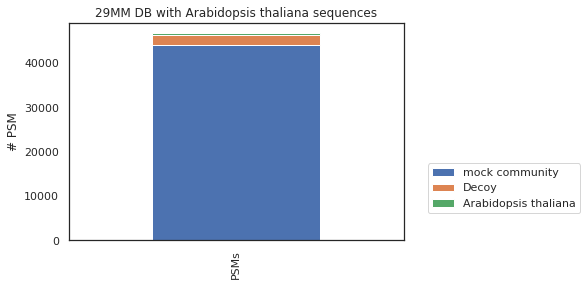

In [226]:
create_stacked_plot(df_from_analysis, "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/arabiopsis_stacked_plot.svg")
print('number of sequences with arabiopsis: 139096, number of sequences without arabiopsis: 123204 , more seq: ', 100 - 123204/139096*100, '%')
print(f"{359/44176*100}% hits are arbiopsis PSMs, assumed false positives: {(359+44176)*0.05}")

    PSMs
0  42596
1   2075
2    519
3    182


0.016456944314020096

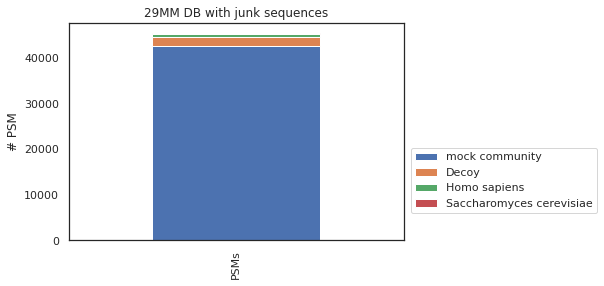

In [234]:
create_stacked_plot(df_more_junk_seq_from_analysis, "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/more_junk_stacked_plot.svg")
(519+182)/42596

In [227]:
46620128 / 220000000 

0.21190967272727274

In [18]:
# create df sensitivity analysis and save
# create_all_analysis_result_df(0.05).to_csv('/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/sensitivity_analysis_0_05_fdr.tsv', sep = '\t')
create_all_analysis_result_df(0.1).to_csv('/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/sensitivity_analysis_0_1_fdr.tsv', sep = '\t')

In [11]:
# load ref file
kleiner_pep_xml_result = pd.read_csv('/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/spectra/Run1_U1_2000ng.pep.xml.tsv', sep='\t')
kleiner_pep_xml_result = kleiner_pep_xml_result.rename(columns={'Peptide': 'Peptide_ref'})
kleiner_pep_xml_result_reduced_df = kleiner_pep_xml_result.groupby(["Title", "Ref_Score"], as_index=False).agg(
            {'ProteinAcc': lambda acc: set(acc), 'Peptide_ref': lambda seq: set(seq)})

In [ ]:
# create single histogramm for reference db
# 1. read df
kleiner_ref_db_df = ReferenceWriter.read_csv_with_generic_function("/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_kleiner_db/Run1_U1_2000ng.t.xml_reduced.tsv",['Protein', 'Hyperscore', 'decoy', 'taxID'])
# create df of right format
df_with_sep_decoy_ref = create_df_for_df_with_sep_decoy(kleiner_ref_db_df)
# get fdr_border
fdr = 0.1
result_file = f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/sensitivity_analysis_0_1_fdr.tsv"
fdr_border = read_value_from_result_file(result_file, 'reference', '-', 'lowest score in FDR')
# plot histogramm
create_histogramm(df_with_sep_decoy_ref, f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/histogramms/histogramm_psm_decoy_reference_{fdr}.svg', fdr_border, fdr)

In [ ]:
# histogram reference and referece aradiopsis
# create df for histogramm, get fdr_borders
levels = ['-']
dbs = ['reference', 'reference with aradiopsis seq']
reduced_tsv_dicts = [reference_tsv_with_kleiner_db, reference_tsv_with_aradiopsis]
df_for_hist = create_all_level_df_for_histogram_per_db(reduced_tsv_dicts, ['reference', 'reference + Arabidopsis thaliana'])
# get fdr_border
for fdr in [0.1, 0.05]:
    result_file = f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/sensitivity_analysis_0_{str(fdr).split('.')[-1]}_fdr.tsv"
    border_list = []
    for db in dbs:
        border_list.append(read_value_from_result_file(result_file, db, levels[0], 'lowest score in FDR'))

    # plot and save histogramm
    output = f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/histogramms/histogramm_psm_decoy_reference_with_ara_{fdr}.svg'
    create_histograms_in_columns_per_db(df_for_hist, border_list, output, 'Reference', fdr, c="database")

In [ ]:
levels = ['subspecies', 'species', 'genus', 'family']
db = 'uniprot_nr'
reduced_tsv_dict = uniprot_nr_reduced_tsv
df_for_hist = create_all_level_df_for_histogram_per_db(reduced_tsv_dict, levels)
# get fdr_border
for fdr in [0.1, 0.05]:
    result_file = f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/sensitivity_analysis_0_{str(fdr).split('.')[-1]}_fdr.tsv"
    border_list = []
    for level in levels:
        border_list.append(read_value_from_result_file(result_file, db, level, 'lowest score in FDR'))
    # plot and save histogramm
    output = f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/histogramms/histogramm_psm_decoy_{db}_with_subspecies_{fdr}.svg'
    create_histograms_in_columns_per_db(df_for_hist, border_list, output, 'UniProtKB', fdr)


In [ ]:
# create df for histogramm, get fdr_borders
levels = ['subspecies', 'species', 'genus']
db = 'ncbi'
reduced_tsv_dict = ncbi_reduced_tsv
df_for_hist = create_all_level_df_for_histogram_per_db(reduced_tsv_dict, levels)
# get fdr_border
for fdr in [0.1, 0.05]:
    result_file = f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/sensitivity_analysis_0_{str(fdr).split('.')[-1]}_fdr.tsv"
    border_list = []
    for level in levels:
        border_list.append(read_value_from_result_file(result_file, db, level, 'lowest score in FDR'))

    # plot and save histogramm
    output = f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/histogramms/histogramm_psm_decoy_{db}_with_subspecies_{fdr}.svg'
    create_histograms_in_columns_per_db(df_for_hist, border_list, output, 'NCBI', fdr)



In [ ]:
# create df for histogramm, get fdr_borders
levels = ['species', 'genus', 'family', 'order']
db = 'swissprot'
reduced_tsv_dict = swissprot_reduced_tsv
df_for_hist = create_all_level_df_for_histogram_per_db(reduced_tsv_dict, levels)
# get fdr_border
for fdr in [0.1, 0.05]:
    result_file = f"/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/sensitivity_analysis_0_{str(fdr).split('.')[-1]}_fdr.tsv"
    border_list = []
    for level in levels:
        border_list.append(read_value_from_result_file(result_file, db, level, 'lowest score in FDR'))

    # plot and save histogramm
    output = f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/histogramms/histogramm_psm_decoy_{db}_{fdr}.svg'
    create_histograms_in_columns_per_db(df_for_hist, border_list, output, 'SwissProt', fdr)


In [ ]:
output = f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/histogramms/histogramm_psm_decoy_ncbi_with_subspecies.svg'
create_histograms_in_columns_per_db(df_ncbi, border_list_ncbi, output, 'NCBI')

In [ ]:
output = f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/histogramms/histogramm_psm_decoy_swissprot.svg'
create_histograms_in_columns_per_db(df_swissprot, border_list_swissprot, output, 'SwissProt')

In [ ]:
# ROC
fdrs = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
files = [f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv_{fdr}_sensitivity'
        for fdr in fdrs]

files_ignore_unclassified = [f'/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv_ignore_unclassified_{fdr}_sensitivity' 
                            for fdr in fdrs]
used_files=files_ignore_unclassified
TP_values = [read_TP(file) for file in used_files]
FN_values = [read_FN(file) for file in used_files]
FP_values = [read_FP(file) for file in used_files]
TN_values = [read_TN(file) for file in used_files]
#fpr = fp/(fp+tn)
fpr_values = [FP_values[i]/(FP_values[i]+TN_values[i]) for i in range(len(used_files))]
#tpr = tp/(tp+fn) = sensitivity
tpr_values =  [TP_values[i]/(TP_values[i]+FN_values[i]) for i in range(len(used_files))]
m = max(tpr_values)
maxes = [i for i, j in enumerate(tpr_values) if j == m]
print('tpr max:', [fdrs[i] for i in maxes])
#print(tpr_values)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
#ax.plot(np.linspace(0, 1, 100),
 #        np.linspace(0, 1, 100),
  #       label='baseline',
   #      linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
#plt.legend(fontsize=12);

In [ ]:
# sensitivity and specificity plot
dict_databases_to_size_and_result_file = get_dict_databases_to_size_and_result_file(0.1)
column_names = ['database', 'level', 'specificity', 'sensitivity']
rows =[['uniprot_nr', 'strain', read_specificity(dict_databases_to_size_and_result_file['uniprot_subspecies'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['uniprot_subspecies'][1])], 
    ['uniprot_nr', 'species', read_specificity(dict_databases_to_size_and_result_file['uniprot_species_nr'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['uniprot_species_nr'][1])], 
       ['uniprot_nr', 'genus', read_specificity(dict_databases_to_size_and_result_file['uniprot_genus_nr'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['uniprot_genus_nr'][1])], 
       ['uniprot_nr', 'family', read_specificity(dict_databases_to_size_and_result_file['uniprot_family_nr'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['uniprot_family_nr'][1])],
       ['ncbi_nr', 'strain', read_specificity(dict_databases_to_size_and_result_file['ncbi_subspecies'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['ncbi_subspecies'][1])],
      ['ncbi_nr', 'species', read_specificity(dict_databases_to_size_and_result_file['ncbi_species'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['ncbi_species'][1])],
       ['ncbi_nr', 'genus', read_specificity(dict_databases_to_size_and_result_file['ncbi_genus'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['ncbi_genus'][1])],
      ['swissprot', 'species', read_specificity(dict_databases_to_size_and_result_file['swissprot_species'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['swissprot_species'][1]) ], 
       ['swissprot', 'genus', read_specificity(dict_databases_to_size_and_result_file['swissprot_genus'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['swissprot_genus'][1]) ], 
       ['swissprot', 'family', read_specificity(dict_databases_to_size_and_result_file['swissprot_family'][1]), 
        read_sensitivity(dict_databases_to_size_and_result_file['swissprot_family'][1]) ]]
df_spe_sens = pd.DataFrame(rows,columns=column_names)
df_spe = df_spe_sens[['database', 'level', 'specificity']]
df_sen = df_spe_sens[['database', 'level', 'sensitivity']]
create_specificity_and_sensitivity_side_by_side_plot(df_spe, df_sen, "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/sens_spec.svg")


In [ ]:
# database size
db_size_files = ["/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/db_size/database_size_kleiner_noRH",
       "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/db_size/database_size_kleiner",
       "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/db_size/database_size_tanca",
       "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/db_size/database_size_tanca_noRH"]
sns.set_style("white") 
output = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/database_size/"
create_db_size_lineplot(db_size_files, output)


In [52]:
number_tanca_spectra = 8471
tanca_nb_identified_spectra_0_05 = {}
for (db_dict, db) in zip([tanca_swissprot_tsv, tanca_uniprot_tsv, tanca_ncbi_tsv], ['swissprot', 'uniprot', 'ncbi']):
    tanca_nb_identified_spectra_0_05[db] = {}
    for k, v in db_dict.items():
        number_psm_result, df = get_psm_and_df_in_fdr(v, 0.05, remove_one_charged_spectra=True, columns=[f'taxid_{k}'])
        df_without_decoy = df[get_hit_rows2(df.decoy)]
        number_spectra = len(set(df_without_decoy.Title))
        tanca_nb_identified_spectra_0_05[db][k] = (number_spectra, number_spectra/number_tanca_spectra*100)
print(tanca_nb_identified_spectra_0_05)


{'swissprot': {'species': (5979, 70.58198559792233), 'genus': (6219, 73.41518120646913), 'family': (6400, 75.55188289458151), 'order': (6583, 77.71219454609846)}, 'uniprot': {'species': (7051, 83.23692598276473), 'genus': (7325, 86.471490969189), 'family': (7119, 84.03966473851966), 'order': (6719, 79.31767205760832)}, 'ncbi': {'species': (7066, 83.41400070829891), 'genus': (7227, 85.31460276236572), 'family': (6873, 81.13563923975919)}}


In [55]:
tanca_nb_identified_spectra_0_1 = tanca_nb_identified_spectra
psm_identified = [tanca_nb_identified_spectra_0_05['uniprot']['species'][1],tanca_nb_identified_spectra_0_05['uniprot']['genus'][1],
                 tanca_nb_identified_spectra_0_05['uniprot']['family'][1], tanca_nb_identified_spectra_0_05['uniprot']['order'][1],
                 tanca_nb_identified_spectra_0_05['ncbi']['species'][1],tanca_nb_identified_spectra_0_05['ncbi']['genus'][1],
                 tanca_nb_identified_spectra_0_05['ncbi']['family'][1],
                 tanca_nb_identified_spectra_0_05['swissprot']['species'][1],tanca_nb_identified_spectra_0_05['swissprot']['genus'][1],
                 tanca_nb_identified_spectra_0_05['swissprot']['family'][1], tanca_nb_identified_spectra_0_05['swissprot']['order'][1],]
df_for_plot_tanca = pd.read_csv("/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/db_size/db_size_psm_tanca.txt", sep="\t")
df_for_plot_tanca['% PSMs identified'] = psm_identified
print(df_for_plot_tanca)

    # fasta (M)    level  % PSMs identified      database dataset
0          1.30  species          83.236926  UniProtKB_NR   Tanca
1          2.90    genus          86.471491  UniProtKB_NR   Tanca
2          7.70   family          84.039665  UniProtKB_NR   Tanca
3         16.40    order          79.317672  UniProtKB_NR   Tanca
4          4.80  species          83.414001          NCBI   Tanca
5          7.80    genus          85.314603          NCBI   Tanca
6         18.40   family          81.135639          NCBI   Tanca
7          0.03  species          70.581986     SwissProt   Tanca
8          0.04    genus          73.415181     SwissProt   Tanca
9          0.07   family          75.551883     SwissProt   Tanca
10         0.14    order          77.712195     SwissProt   Tanca


In [42]:
# database-size vs. PSMs
full_df = create_all_analysis_result_df(0.1)
number_of_spectra = 164414
number_of_spectra_passing_quality_control = 88279
PSM_identified_uniprot = get_psm_per_db_from_sens_analysis(full_df, 'uniprot')
PSM_identified_ncbi = get_psm_per_db_from_sens_analysis(full_df, 'ncbi')
PSM_identified_swissprot = get_psm_per_db_from_sens_analysis(full_df, 'swissprot')
PSM_identified_ncbi_percentage = [psm/number_of_spectra_passing_quality_control * 100 for psm in PSM_identified_ncbi]
PSM_identified_uniprot_percentage= [psm/number_of_spectra_passing_quality_control * 100 for psm in PSM_identified_uniprot]
PSM_identified_swissprot_percentage= [psm/number_of_spectra_passing_quality_control * 100 for psm in PSM_identified_swissprot]
uniprot_database_sizes = [uniprot_nr_db[0]/1000000 for uniprot_nr_db in uniprot_nr_dict.values()]
ncbi_database_sizes = [ncbi_db[0]/1000000 for ncbi_db in ncbi_dict.values()]
swissprot_database_sizes = [swissprot_db[0]/1000000 for swissprot_db in swissprot_dict.values()]


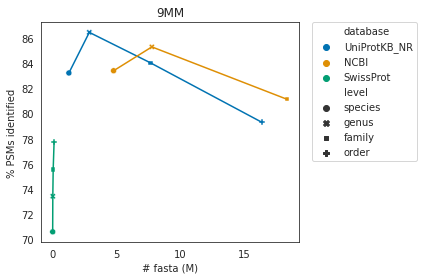

In [63]:
# database-size vs. PSMs Plots
# identified PSMs deutlich abweichend von Bachelor-Analyse
# columns:  # fasta (M)    level  % PSMs identified   database  dataset    
df_for_plot_kleiner = create_pd_df_for_psm_plot(PSM_identified_uniprot_percentage, PSM_identified_ncbi_percentage, uniprot_database_sizes, ncbi_database_sizes, PSM_identified_swissprot_percentage, swissprot_database_sizes)
all_result_df = create_all_analysis_result_df(0.1)
#print(all_result_df)
df_reference = pd.DataFrame([[0.01, 'species', 51320/number_of_spectra_passing_quality_control*100, 'Reference', "kleiner"]], columns=["# fasta (M)", "level", "% PSMs identified", "database", "dataset"])
df_for_plot_kleiner = df_for_plot_kleiner.append(df_reference)
# kleiner
create_fasta_size_vs_identifed_psms_plot(df_for_plot_kleiner, "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/database_size/kleiner_uni_ncbi_db_psm_vs_db_size_0_1_with_reference.svg")
#tanca
create_fasta_size_vs_identifed_psms_plot(df_for_plot_tanca, "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/database_size/tanca_uni_ncbi_db_psm_vs_db_size_0_05.svg")

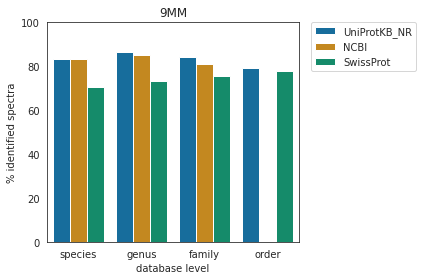

In [66]:
#PSMs 
outputfiles = [
    "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/PSM/kleiner_psm_vs_level_0_1.svg",
    "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/PSM/tanca_psm_vs_level_0_05.svg"
]
# crated psm vs dbsize plot
#  # fasta (M) database level  % identified spectra   database  dataset
df_for_plot_all_db = create_pd_df_for_psm_plot(PSM_identified_uniprot_percentage, PSM_identified_ncbi_percentage, uniprot_database_sizes, ncbi_database_sizes, PSM_identified_swissprot_percentage, swissprot_database_sizes)
df_for_plot_all_db = df_for_plot_all_db[df_for_plot_all_db.level != 'order']
df_for_plot_all_db = df_for_plot_all_db.rename(columns={'level': 'database level', '% PSMs identified': "% identified spectra"})
df_for_plot_all_db_tanca = df_for_plot_tanca.rename(columns={'level': 'database level', '% PSMs identified': "% identified spectra"})
create_database_level_vs_identified_barplot(df_for_plot_all_db, 'kleiner', outputfiles[0])
create_database_level_vs_identified_barplot(df_for_plot_all_db_tanca, 'tanca', outputfiles[1])
#df_reference = pd.DataFrame([[0.01, 'species', 51320/number_of_spectra_passing_quality_control*100, 'Reference', "kleiner"]], columns=["# fasta (M)", "database level", "% PSMs identified", "database", "dataset"])
#print(df_for_plot_all_db)
#create_database_level_vs_identified_barplot(df_reference, 'kleiner', "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/PSM/reference_psm.svg")

In [48]:
print(df_for_plot_all_db)

   # fasta (M) database level  % identified spectra   database  dataset
0     0.200000         strain             41.556882  UniProtKB  kleiner
1     2.991727        species             49.771746  UniProtKB  kleiner
2    13.210287          genus             46.296401  UniProtKB  kleiner
3    22.509624         family             45.921454  UniProtKB  kleiner
4     0.300000         strain             41.556882       NCBI  kleiner
5     8.702135        species             50.185208       NCBI  kleiner
6    27.804893          genus             46.647561       NCBI  kleiner
7     0.058505        species             28.217356  Swissprot  kleiner
8     0.088164          genus             29.176814  Swissprot  kleiner
9     0.124044         family             29.227789  Swissprot  kleiner


In [ ]:
# 92470
merged_df_u, final_decoy_list_u, identified_spectra_of_all_levels_together_u = get_merged_df_of_all_levels(uniprot_nr_reduced_tsv, 0.1, ["subspecies", "species", "genus", "family"])
perc_all_u_0_05 = identified_spectra_of_all_levels_together_u/number_of_spectra_passing_quality_control*100
print(perc_all_u_0_05)
path = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/uniprot_all_level_merged.tsv"
# merged_df_u[final_decoy_list_u][['Title', 'decoy_subspecies', 'decoy_species', 'decoy_genus', 'decoy_family']].to_csv(path, sep='\t')

In [ ]:
merged_df_n, final_decoy_list_n, identified_spectra_of_all_levels_together_n = get_merged_df_of_all_levels(ncbi_reduced_tsv, 0.1, ["subspecies", "species", "genus"])
perc_all_n_0_1 = identified_spectra_of_all_levels_together_n/number_of_spectra_passing_quality_control*100
print(perc_all_n_0_1)

In [ ]:
merged_df_s, final_decoy_list_s, identified_spectra_of_all_levels_together_s = get_merged_df_of_all_levels(swissprot_reduced_tsv, 0.1, ["species", "genus", "family", "order"])
perc_all_s_0_1 = identified_spectra_of_all_levels_together_s/number_of_spectra_passing_quality_control*100
print(perc_all_s_0_1)

   # fasta (M) database level  % identified spectra   database  dataset
0          0.2         strain             41.556882  UniProtKB  kleiner
1     2.991727        species             49.771746  UniProtKB  kleiner
2    13.210287          genus             46.296401  UniProtKB  kleiner
3    22.509624         family             45.921454  UniProtKB  kleiner
4          0.3         strain             41.556882       NCBI  kleiner
5     8.702135        species             50.185208       NCBI  kleiner
6    27.804893          genus             46.647561       NCBI  kleiner
7     0.058505        species             28.217356  Swissprot  kleiner
8     0.088164          genus             29.176814  Swissprot  kleiner
9     0.124044         family             29.227789  Swissprot  kleiner
10                     united             58.515615  UniProtKB  kleiner
11                     united             57.611663       NCBI  kleiner
12                     united             33.932192  Swissprot  

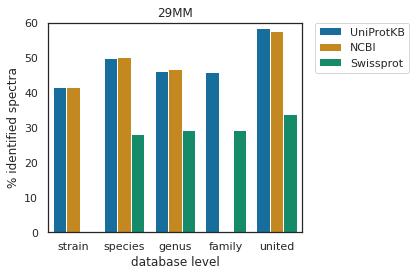

In [143]:
def add_united_values(df, uni_united, ncbi_united, swiss_united=None):
    # columns =['# fasta (M)', 'level', '% PSMs identified', 'database', 'dataset']
    df.loc[df.index.max() + 1] = ['', 'united', uni_united, 'UniProtKB', 'kleiner']
    df.loc[df.index.max() + 1] = ['', 'united', ncbi_united, 'NCBI', 'kleiner']
    df.loc[df.index.max() + 1] = ['', 'united', swiss_united, 'Swissprot', 'kleiner']
    return df
perc_all_u_0_05 = 50.17274776560677
perc_all_n_0_05 = 49.22914849511209
perc_all_s_0_05 = 29.03861620543957
perc_all_u_0_1 = 58.515615265238615
perc_all_n_0_1 = 57.611663022915984
perc_all_s_0_1 = 33.93219225410347
df_for_plot_all_db_with_united = add_united_values(df_for_plot_all_db, perc_all_u_0_1, perc_all_n_0_1, perc_all_s_0_1)
#  # fasta (M) database level  % identified spectra   database  dataset
df_for_plot_all_db_with_united.columns = ['# fasta (M)', 'database level', '% identified spectra', 'database', 'dataset']

print(df_for_plot_all_db_with_united)
create_database_level_vs_identified_barplot(df_for_plot_all_db_with_united, 'kleiner', "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/PSM/kleiner_psm_vs_level_united_0_1.svg")

In [37]:
# deviation PSM new calculated
path_to_mean_deviation_df = ["/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/mean_deviation_kleiner",
        "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/mean_deviation_tanca"]
sns.set_style("white") 

for file in path_to_mean_deviation_df:
    deviation_df = create_mean_deviation_df(input_files)
    print(deviation_df)
    if 'kleiner' in file:
        title = '29MM'
        g = sns.catplot(x='level', y='mean deviation', hue='database', linestyles=["-", "-", "-"], kind="point", palette=['red','blue','purple'], data=deviation_df)  
       # plt.ylim([0,5])
    elif 'tanca' in file:
        title = '9MM'
        g = sns.catplot(x='level', y='mean deviation', hue='database', linestyles=["--", "--", "--"], kind="point", palette=['red','blue','purple'], data=deviation_df)  
    plt.ylim([0,13])
    plt.ylabel('mean deviation (%)')
    #g.fig.suptitle(title)
    g.savefig(file+".svg", format='svg')

Load taxon graph from harddrive.
taxID viruses not in taxdump, continue...
Load taxon graph from harddrive.
taxID viruses not in taxdump, continue...


KeyboardInterrupt: 

         level    database dataset  mean deviation
0   subspecies     UniProt    29MM            2.01
1      species     UniProt    29MM            1.87
2        genus     UniProt    29MM            2.56
3       family     UniProt    29MM            3.16
4   subspecies     NCBI-nr    29MM            3.80
5      species     NCBI-nr    29MM            1.92
6        genus     NCBI-nr    29MM            2.74
7   subspecies  Swiss-Prot    29MM            2.99
8      species  Swiss-Prot    29MM            2.56
9        genus  Swiss-Prot    29MM            2.68
10      family  Swiss-Prot    29MM            1.74
      level    database dataset  mean deviation
0   species     UniProt     9MM            6.79
1     genus     UniProt     9MM            6.50
2    family     UniProt     9MM            8.29
3     order     UniProt     9MM            8.99
4   species     NCBI-nr     9MM            7.16
5     genus     NCBI-nr     9MM            6.24
6    family     NCBI-nr     9MM            8.11
7   

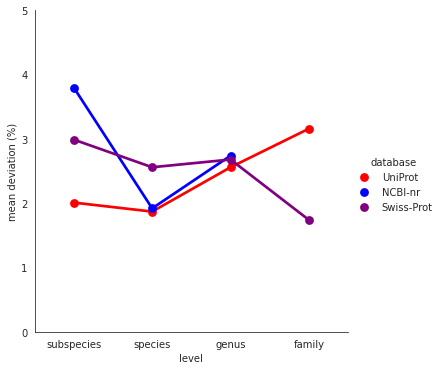

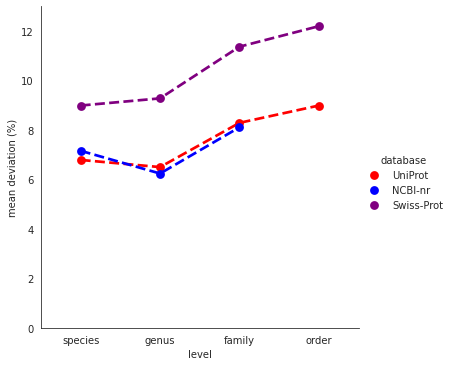

In [21]:
# deviation PSM bases on bachelor results
path_to_mean_deviation_df = ["/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/mean_deviation_kleiner",
        "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/mean_deviation_tanca"]
sns.set_style("white") 

for file in path_to_mean_deviation_df:
    deviation_df = pd.read_csv(file+".txt", sep='\t')
    print(deviation_df)
    if 'kleiner' in file:
        title = '29MM'
        g = sns.catplot(x='level', y='mean deviation', hue='database', linestyles=["-", "-", "-"], kind="point", palette=['red','blue','purple'], data=deviation_df)  
       # plt.ylim([0,5])
    elif 'tanca' in file:
        title = '9MM'
        g = sns.catplot(x='level', y='mean deviation', hue='database', linestyles=["--", "--", "--"], kind="point", palette=['red','blue','purple'], data=deviation_df)  
    plt.ylim([0,13])
    plt.ylabel('mean deviation (%)')
    #g.fig.suptitle(title)
    g.savefig(file+".svg", format='svg')

In [11]:
input_files = {
    'uniprot':
    [(uniprot_nr_reduced_tsv["subspecies"], 
      "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_unidb_strain.txt", "subspecies"),
     (uniprot_nr_reduced_tsv["species"],
      "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_unidb_species.txt", "species"),
    (uniprot_nr_reduced_tsv["genus"],
     "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_unidb_genus.txt","genus"),
    ( uniprot_nr_reduced_tsv["family"],
     "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_unidb_family.txt", "family")],
    "ncbi":
    [(ncbi_reduced_tsv["subspecies"],
     "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_ncbidb_strain.txt", "subspecies"),
     (ncbi_reduced_tsv["species"],
      "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_ncbidb_species.txt", "species"),
     (ncbi_reduced_tsv["genus"],
      "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_ncbidb_genus.txt", "genus")],
     "swissprot":
    [(swissprot_reduced_tsv["species"],
      "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_swissprot_species.txt", 'species'),
    (swissprot_reduced_tsv["genus"],
     "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_swissprot_genus.txt", "genus"),
    (swissprot_reduced_tsv["family"],
     "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_swissprot_family.txt", "family"),
    (swissprot_reduced_tsv["order"],
     "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_swissprot_order.txt", "order")]
}

other_files = ["/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/taxon_specific_identification&db/Kleiner_ncbidb_genus_species",
              ]
outputpath = "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/taxon_specific_identification/"
fdr = 0.1
for files in input_files['swissprot']:
    create_psms_per_taxID_plot(files[0], files[1], files[2], fdr, outputpath)
fdr = 0.1
for files in input_files['ncbi']:
    create_psms_per_taxID_plot(files[0], files[1], files[2], fdr, outputpath)
fdr = 0.1
for files in input_files['uniprot']:
    create_psms_per_taxID_plot(files[0], files[1], files[2], fdr, outputpath)


In [ ]:
# % PSM identified barplot
#PSMs 
input_files = [
    "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/PSM/PSM_kleiner_ncbi_vs_uniprot_vs_swissprot",
    # "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/PSM/PSM_tanca_ncbi_vs_uniprot_vs_swissprot"
]
create_identified_spectra_barplot(input_files)


In [ ]:
# database-size vs. PSMs
input_files = ["/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/db_size/db_size_psm_tanca.txt",
        "/home/jules/Documents/Metaproteomics/Bachelorarbeit/Graphiken/db_size/db_size_psm_kleiner.txt"]
create_psm_identified_vs_db_size_with_ref(0.05, input_files[1])

In [ ]:
from number_of_psm_per_species import PsmNumberPerTaxIDs
obj = PsmNumberPerTaxIDs('kleiner', input_files['uniprot'][0][0], input_files['uniprot'][0][2])
taxID_to_spectra_dict = obj.count_row_by_row()
taxID_to_spectra_dict = obj.get_virus_spectra(taxID_to_spectra_dict)
taxID_to_percentage_dict = obj.get_percentage(taxID_to_spectra_dict)
print(taxID_to_percentage_dict)

In [ ]:
uni_spec_in_fdr = get_df_in_fdr(uniprot_reduced_tsv_species_df, 0.1)
# kleiner_pep_xml_result:  Title ProteinAcc  Peptide  Ref_Score
# uni_spec_in_fdr: reduced_df of uniprot species matches in FDR-border: Title Peptide  Hyperscore taxID  decoy 
print('number of identified spectra by Kleiner: ', len(set(kleiner_pep_xml_result['Title'].tolist())))
print('number of identified spectra by Uniprot species: ', len(set(uni_spec_in_fdr['Title'].tolist())))
# Title  Ref_Score  ProteinAcc Peptide_x (set)  Peptide_y(string)  Hyperscore   taxID    decoy
merged_pep_xml_uniprot_df = pd.merge(kleiner_pep_xml_result_reduced_df, uni_spec_in_fdr, how="outer", left_on='Title', right_on="Title")
df_identified_in_uniprot = merged_pep_xml_uniprot_df[merged_pep_xml_uniprot_df['Peptide_ref'].isna()]
df_identified_in_kleiner_ref = merged_pep_xml_uniprot_df[merged_pep_xml_uniprot_df['Peptide'].isna()]
print('number of spectra identified in uniprot species result but not in kleiner: ', len(set(df_identified_in_uniprot['Title'].tolist())))
print('number of spectra identified in kleiner but not in uniprot species result: ', len(set(df_identified_in_kleiner_ref['Title'].tolist())))

In [ ]:
# test of df with one charge spectra and so

# now all reduced dataframes without charge one spectra (_new_reduced)
uniprot_reduced_tsv_species_nr_new_df = ReferenceWriter.read_csv_with_generic_function(uniprot_nr_reduced_tsv['species'],['Protein', 'Hyperscore', 'decoy', 'taxID'], remove_one_charged_spectra=True)
print('number spectra of new reduced df: ',len(uniprot_reduced_tsv_species_nr_new_df))
uniprot_reduced_tsv_species_nr_new_df = ReferenceWriter.read_csv_with_generic_function(uniprot_nr_reduced_tsv['species'],['Protein', 'Hyperscore', 'decoy', 'taxID'], remove_one_charged_spectra=False)
print('number spectra of new reduced df (removed one charge spectra): ',len(uniprot_reduced_tsv_species_nr_new_df))
uniprot_reduced_tsv_species_nr_old_df = ReferenceWriter.read_csv_with_generic_function( "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv",['Protein', 'Hyperscore', 'decoy', 'taxID'], remove_one_charged_spectra=False)
print('number spectra of old reduced df (with one charge spectra): ',len(uniprot_reduced_tsv_species_nr_old_df))
uniprot_reduced_tsv_species_nr_old_df = ReferenceWriter.read_csv_with_generic_function( "/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/results_searchgui_xtandem_analyzer_bachelor_thesis/uniprot/x_tandem_tsv/Run1_U1_2000ng_uniprot_species_nr.t.xml_reduced.tsv",
                                                                                       ['Protein', 'Hyperscore', 'decoy', 'taxID'], remove_one_charged_spectra=True)
print('number spectra of old reduced df (removed one charge spectra): ', len(uniprot_reduced_tsv_species_nr_old_df))
# check if same df, also new analysis old analysis
# a = pd.merge(uniprot_reduced_tsv_species_nr_new_df[['Title', 'Peptide']], uniprot_reduced_tsv_species_nr_old_df[['Title', 'Peptide']], how="outer", on='Title')
# Test for differences old and new analysis
excluded_spectra = set(a[a.Peptide_x.isna()]['Title']) # 46701
print(len(set(a[a.Peptide_y.isna()]['Title']))) # 0
excluded_spectra_with_number_at_last_pos = set([spectrum for spectrum in a[a.Peptide_x.isna()]['Title'] if spectrum.split('.')[-1] != '' ])
included_spectra = uniprot_reduced_tsv_species_nr_new_df['Title']
included_spectra_without_number_at_last_pos = set([spectrum for spectrum in included_spectra if spectrum.split('.')[-1] == '' ])
print(included_spectra_without_number_at_last_pos)
excluded_spectra_without_number_at_last_pos = set([spectrum for spectrum in excluded_spectra if spectrum.split('.')[-1] == '' ])
print(len(excluded_spectra))
print(a[a.Peptide_y == 'VGDYTVAIGNPFGLGETVTSGIVSALGR']) # Spectrum Run1_U1_2000ng.151046.151046. und Run1_U1_2000ng.151255.151255. not passed quality control new analysis
uniprot_reduced_tsv_genus_nr_new_df = ReferenceWriter.read_csv_with_generic_function(uniprot_nr_reduced_tsv['genus'],['Protein', 'Hyperscore', 'decoy', 'taxID'])
intersect = set(uniprot_reduced_tsv_genus_nr_new_df['Title']).intersection(excluded_spectra)
print(sorted(list(excluded_spectra_with_number_at_last_pos)))
print(sorted(list(intersect)))
ncbi_reduced_tsv_subspecies_old_df = ReferenceWriter.read_csv_with_generic_function( ncbi_reduced_tsv['subspecies'], ['Protein', 'Hyperscore', 'decoy', 'taxID'])
print(len(ncbi_reduced_tsv_subspecies_old_df))
ncbi_reduced_tsv_subspecies_new = remove_spectra_of_charge_one_from_reduced_tsv(ncbi_reduced_tsv_subspecies_old_df)
print(len(ncbi_reduced_tsv_subspecies_new))

In [ ]:
uni_spec_in_fdr = uni_spec_in_fdr.rename(columns={'Peptide': 'Peptide_uni'})
merged_pep_xml_uniprot_df = pd.merge(kleiner_pep_xml_result_reduced_df, uni_spec_in_fdr, how="outer", on="Title")
a = pd.merge(merged_pep_xml_uniprot_df_er, merged_pep_xml_uniprot_df, how="outer", on='Title')
b = a[a['Peptide_uni'].isna()][['Title', 'Peptide_ref_x', 'Peptide_ref_y', 'Peptide_uni', 'Peptide_er']]
c = b[b['Peptide_er'].notna()]
d = c[c['Peptide_ref_x'].notna()]
# without quality control: 8 specta more identified (equal to kleiner_ref), all other trash

In [92]:
# load taxon graph
import sys  
sys.path.insert(0, '/home/jules/tax2proteome_projects/tax2proteome/')
from TaxonGraph import TaxonGraph
taxon_graph = TaxonGraph()
taxon_graph.create_graph("/home/jules/Documents/Metaproteomics/databases/databases_tax2proteome/taxdump.tar.gz")

/tmp/ipykernel_9113/1821572622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = df[column_name].apply(lambda taxid: taxon_graph.get_scientific_name(taxid) if taxid not in ['CRAP', 'DECOY'] else taxid)


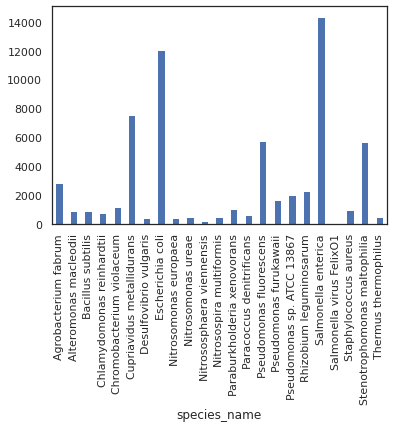

In [269]:
file=uniprot_nr_reduced_tsv['species']
fdr=0.05
df_uni_species = get_psm_and_df_in_fdr(file, fdr, remove_one_charged_spectra=True, columns=["taxID_species"])[1]
df_uni_species_without_set = df_uni_species.explode('taxID_species').reset_index(drop=True)
df_uni_species_without_crap = df_uni_species_without_set[[True if t_set != "CRAP" else False for t_set in df_uni_species_without_set.taxID_species]]
df_uni_species_without_decoy = df_uni_species_without_crap[[True if t_set != "DECOY" else False for t_set in df_uni_species_without_crap.taxID_species]]

create_nb_of_psms_per_species_barplot_and_csv(df_uni_species_without_decoy, 'taxID_species', '/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/nb_psm_per_species_barplot_and_csv/nb_psm_per_species_uni', taxon_graph)

/tmp/ipykernel_9113/1821572622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = df[column_name].apply(lambda taxid: taxon_graph.get_scientific_name(taxid) if taxid not in ['CRAP', 'DECOY'] else taxid)


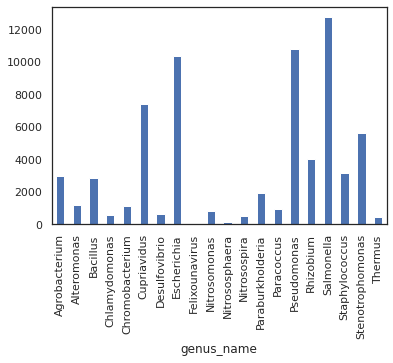

In [267]:
file=uniprot_nr_reduced_tsv['genus']
fdr=0.05
df_uni_genus = get_psm_and_df_in_fdr(file, fdr, remove_one_charged_spectra=True, columns=["taxID_genus"])[1]
df_uni_genus_without_set = df_uni_genus.explode('taxID_genus').reset_index(drop=True)
df_uni_genus_without_crap = df_uni_genus_without_set[[True if t_set != "CRAP" else False for t_set in df_uni_genus_without_set.taxID_genus]]
df_uni_genus_without_decoy = df_uni_genus_without_crap[[True if t_set != "DECOY" else False for t_set in df_uni_genus_without_crap.taxID_genus]]

create_nb_of_psms_per_species_barplot_and_csv(df_uni_genus_without_decoy, 'taxID_genus', '/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/nb_psm_per_species_barplot_and_csv/nb_psm_per_genus_uni', taxon_graph)

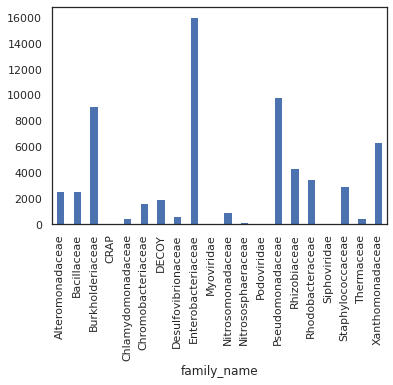

In [241]:
file=uniprot_nr_reduced_tsv['family']
fdr=0.05
df_uni_family = get_psm_and_df_in_fdr(file, fdr, remove_one_charged_spectra=True, columns=["taxID_family"])[1]
df_uni_family_without_set = df_uni_family.explode('taxID_family').reset_index(drop=True)

create_nb_of_psms_per_species_barplot_and_csv(df_uni_family_without_set, 'taxID_family', '/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/nb_psm_per_species_barplot_and_csv/nb_psm_per_family_uni', taxon_graph)

63792
63776


/tmp/ipykernel_9113/1821572622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column_name] = df[column_name].apply(lambda taxid: taxon_graph.get_scientific_name(taxid) if taxid not in ['CRAP', 'DECOY'] else taxid)


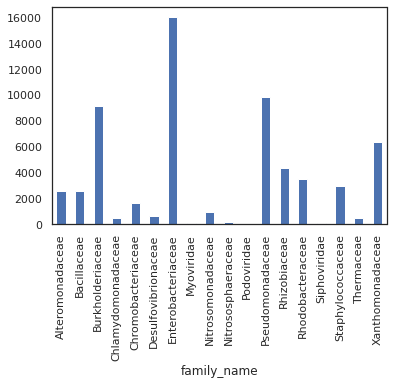

In [265]:
print(len(df_uni_family_without_set))
len(df_uni_family_without_decoy)
create_nb_of_psms_per_species_barplot_and_csv(df_uni_family_without_decoy, 'taxID_family', '/home/jules/Documents/Metaproteomics/Tax2Proteome/benchmarking/plots/nb_psm_per_species_barplot_and_csv/nb_psm_per_family_uni', taxon_graph)